In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

!tar -xf /content/cifar-10-python.tar.gz

--2022-05-27 14:11:15--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  42.6MB/s    in 5.6s    

2022-05-27 14:11:21 (28.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset, Dataset
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import skimage.transform
import torchvision.models as models
import numpy as np
import random
from tqdm import tqdm

import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

import cv2
from PIL import Image
import matplotlib.image as img
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(156)

if device == "cuda":
  torch.cuda.manual_seed_all(156)


In [ ]:
transform_train = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                transforms.RandomCrop(32),
                                transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

cifar10_train = dsets.CIFAR10(root = "CIFAR100_data/",train=True,transform = transform,download=True)
cifar10_test = dsets.CIFAR10(root="CIFAR100_data/",train=False,transform=transform,download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR100_data/cifar-10-python.tar.gz to CIFAR100_data/
Files already downloaded and verified


In [ ]:
X_train_img = cifar10_train.data / 255.0
y_train_img = np.array(cifar10_train.targets)

X_train = cifar10_train.data
y_train = np.array(cifar10_train.targets)

X_test = cifar10_test.data
y_test = np.array(cifar10_test.targets)

X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2,shuffle=True,random_state=156)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.X = torch.FloatTensor(self.X).permute(0,3,1,2)
    self.y = torch.LongTensor(self.y)
    self.transform = transform

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):

    img = self.X[index]
    label = self.y[index]

    if self.transform is not None:
      img = self.transform(img)

    return (img, label)

In [ ]:
index = random.sample(list(range(1,40001)),10)
class_to_idx = cifar10_train.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}

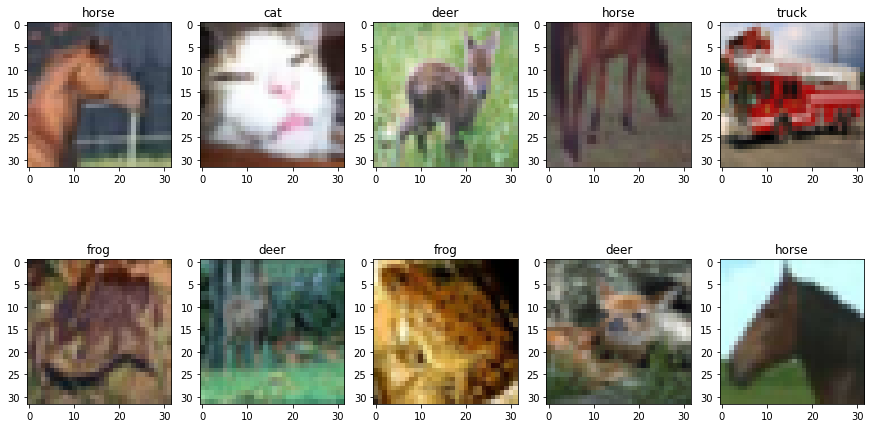

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(15,8))

for i in range(10):
  ax[i//5][i%5].imshow(X_train_img[index][i])
  label = idx_to_class[y_train_img[index][i].item()]
  ax[i//5][i%5].set_title(label)

In [ ]:
train_tensor = CustomDataset(X_train,y_train,transform=transform)
valid_tensor = CustomDataset(X_valid,y_valid,transform=transform)
test_tensor = CustomDataset(X_test,y_test,transform=transform)

train_loader = DataLoader(train_tensor,batch_size=128,shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_tensor,batch_size=128,shuffle=False,drop_last=True)
test_loader = DataLoader(test_tensor,batch_size=32,shuffle=False)

In [ ]:
class VGG(nn.Module):
  def __init__(self,num_classes,batch_normalization,dropout):
    super().__init__()

    if (batch_normalization == True) and (dropout == False) :

      self.features = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=5),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64,128,kernel_size=3,padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128,256,kernel_size=3,padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256,256,kernel_size=3,padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(256,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
      )
    
    elif (batch_normalization == False) and (dropout == False) :
      
      self.features = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=5),
          nn.ReLU(),
          nn.Conv2d(64,128,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(128,256,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(256,256,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(256,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
      )

    elif (batch_normalization == True) and (dropout == True) :

      self.features = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=5),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64,128,kernel_size=3,padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128,256,kernel_size=3,padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256,256,kernel_size=3,padding=1),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.2),
          nn.Conv2d(256,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.2)
      )

    elif (batch_normalization == False) and (dropout == True) :

      self.features = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=5),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Conv2d(64,128,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Conv2d(128,256,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Conv2d(256,256,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.2),
          nn.Conv2d(256,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.2)
      )

    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    
    self.classifier = nn.Sequential(
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )

    self.initialize_weights()

  def forward(self,x):
    
    map = self.features(x)
    x = self.avg_pool(map)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x, map

  def initialize_weights(self):

    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.constant_(m.bias,0)
      
      elif isinstance(m,nn.BatchNorm2d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias,0)
      
      elif isinstance(m,nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias,0)

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
    self.pooling = model.avg_pool
    self.fc = model.classifier[0:3]

  def forward(self,x):
    out = self.features(x)
    out = self.pooling(out)
    out = out.view(out.size(0),-1)
    out = self.fc(out)
    return out

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

In [ ]:
class VGG(nn.Module):

  def __init__(self,num_classes=10, batch_normalization=True):
    super().__init__()

    if batch_normalization == True:

      self.features = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64,128,kernel_size=5),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128,128,kernel_size=3,padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(128,256,kernel_size=3,padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256,512,kernel_size=3,padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
      )
    
    else :

      self.features = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=3),
          nn.ReLU(),
          nn.Conv2d(64,128,kernel_size=5),
          nn.ReLU(),
          nn.Conv2d(128,128,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(128,256,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(256,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
      )

    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Sequential(
          nn.Linear(512,1024),
          nn.ReLU(),
          nn.Linear(1024,512),
          nn.ReLU(),
          nn.Linear(512,10)
      )
      
  def forward(self,x):

    map = self.features(x)
    x = self.avg_pool(map)
    x = x.view(x.size(0),-1)  
    x = self.classifier(x)

    return x, map

def init_weights(self):

  for m in self.modules():
    if isinstance(m,nn.Conv2d):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
        nn.init.constant_(m.bias,0)
    
    elif isinstance(m,nn.BatchNorm2d):
      nn.init.constant_(m.weight,1)
      nn.init.constant_(m.bias,0)
    
    elif isinstance(m,nn.Linear):
      nn.init.kaiming_uniform_(m.weight)
      nn.init.constant(m.bias,0)


In [ ]:
model = VGG(num_classes=10, batch_normalization = True, dropout = False).to(device)
#model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 15

In [ ]:
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
best_valid_accuracy = 0

for epoch in range(epochs):

  model.train()
  
  train_avg_loss = 0
  valid_avg_loss = 0
  train_correct = 0
  valid_correct = 0

  for X,y in train_loader:
    
    X = X.to(device)
    y = y.to(device)

    outputs,_ = model(X)
    train_correct += torch.sum(outputs.argmax(dim=1) == y).detach().cpu().item()

    loss = criterion(outputs,y)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    train_avg_loss += loss / len(train_loader)
  
  train_accuracy.append(train_correct / len(train_loader.dataset) * 100)
  train_loss.append(train_avg_loss.detach().cpu().item())

  model.eval()
  for X,y in valid_loader:
  
    with torch.no_grad():
      X = X.to(device)
      y = y.to(device)

      outputs,_ = model(X)
      valid_correct += torch.sum(outputs.argmax(dim=1) == y).detach().cpu().item()

      loss = criterion(outputs,y)
      valid_avg_loss += loss / len(valid_loader)

  valid_accuracy.append(valid_correct / len(valid_loader.dataset) * 100)
  valid_loss.append(valid_avg_loss.detach().cpu().item())

  torch.save({
      "epoch" : epoch + 1,
      "optimizer_state_dict":optimizer.state_dict(),
      "model_state_dict":model.state_dict(),
      "train_loss":train_avg_loss,
      "valid_loss":valid_avg_loss,
      "description" : f"체크포인트 {epoch + 1}"
  },f"/content/drive/MyDrive/model_batchnormalization_dropout_checkpoint_{epoch + 1}.pt")

  print("epoch : {}일때 train loss : {:.3f} train accuracy : {:.2f}% valid loss : {:.3f} valid accuracy : {:.2f}%".format(epoch+1,train_avg_loss,train_correct / len(train_loader.dataset) * 100, valid_avg_loss, valid_correct / len(valid_loader.dataset) * 100))


epoch : 1일때 train loss : 3.247 train accuracy : 13.87% valid loss : 2.205 valid accuracy : 14.37%
epoch : 2일때 train loss : 2.170 train accuracy : 15.84% valid loss : 2.050 valid accuracy : 17.71%
epoch : 3일때 train loss : 2.060 train accuracy : 17.58% valid loss : 1.921 valid accuracy : 22.57%
epoch : 4일때 train loss : 1.914 train accuracy : 23.27% valid loss : 1.861 valid accuracy : 25.46%
epoch : 5일때 train loss : 1.777 train accuracy : 28.71% valid loss : 1.702 valid accuracy : 35.72%


KeyboardInterrupt: ignored

In [ ]:
for X,y in train_loader:
  break    
X = X.to(device)
y = y.to(device)

In [ ]:
model.features(X).size()

torch.Size([128, 512, 7, 7])

In [ ]:
train_model_loss = [2.3051459789276123,
 2.3027265071868896,
 2.30267333984375,
 2.3026912212371826,
 2.3026793003082275,
 2.3026585578918457,
 2.302666425704956,
 2.3026578426361084,
 2.302669048309326,
 2.3026697635650635,
 2.3026788234710693,
 2.3026607036590576,
 2.3026790618896484,
 2.30267596244812,
 2.3026692867279053]

valid_model_loss  = [2.3026599884033203,
 2.302751064300537,
 2.302729368209839,
 2.302779197692871,
 2.3027892112731934,
 2.3027894496917725,
 2.3027660846710205,
 2.3027687072753906,
 2.302779197692871,
 2.302762508392334,
 2.3027822971343994,
 2.302738666534424,
 2.3027870655059814,
 2.302783250808716,
 2.302812099456787]

train_model_accuracy = [9.9125,
 9.822500000000002,
 9.8125,
 9.9375,
 9.675,
 9.9825,
 9.635,
 9.93,
 9.887500000000001,
 9.9625,
 9.897499999999999,
 10.012500000000001,
 10.084999999999999,
 9.76,
 9.8675]

valid_model_accuracy = [9.92,
 9.54,
 9.54,
 9.85,
 9.54,
 9.54,
 9.54,
 9.85,
 9.54,
 9.54,
 9.54,
 9.54,
 9.54,
 9.54,
 9.54]

train_dropout_loss = [1.997,1.661,1.457,1.294,1.160,1.047,0.967,0.886,0.822,0.759,0.705,0.671,0.624,0.587,0.558]
valid_dropout_loss = [1.777,1.612,1.364,1.219,1.120,1.026,0.938,0.850,0.826,0.779,0.798,0.750,0.671,0.689,0.658]
train_dropout_accuracy = [20.96,35.30,45.51,52.06,57.31,61.98,65.31,68.02,70.53,72.84,74.90,76.34,77.88,79.20,80.28]
valid_dropout_accuracy = [28.44,38.42,49.04,55.58,59.51,63.75,67.05,69.65,71.12,72.48,72.70,74.56,77.15,76.70,78.22]

train_batchnormalization_loss = [1.6738436222076416,
 1.218887209892273,
 0.9705267548561096,
 0.8100123405456543,
 0.6937205791473389,
 0.6022904515266418,
 0.52841717004776,
 0.4589173197746277,
 0.4069129228591919,
 0.35853004455566406,
 0.3099508583545685,
 0.27825918793678284,
 0.23368410766124725,
 0.20531179010868073,
 0.1834322065114975]

valid_batchnormalization_loss = [1.4429665803909302,
 1.2192891836166382,
 0.9464386105537415,
 0.9631891250610352,
 0.8281022310256958,
 0.6734579801559448,
 0.7891807556152344,
 0.7813830971717834,
 0.6354749798774719,
 0.6120226979255676,
 0.6048277616500854,
 0.5814105272293091,
 0.5537344217300415,
 0.6904757022857666,
 0.5652106404304504]

train_batchnormalization_accuracy = [37.1,
 54.99000000000001,
 64.97749999999999,
 71.1275,
 75.6275,
 78.685,
 81.5725,
 83.94,
 86.065,
 87.355,
 88.91250000000001,
 90.03750000000001,
 91.7225,
 92.685,
 93.62]

valid_batchnormalization_accuracy = [45.17,
 57.16,
 65.88000000000001,
 65.78,
 71.12,
 76.75999999999999,
 73.29,
 74.53,
 79.43,
 79.94,
 80.63,
 81.78999999999999,
 83.26,
 80.97,
 83.32000000000001]

train_batchnormalization_dropout_loss = [1.702218770980835,
 1.308389663696289,
 1.0813995599746704,
 0.9329952597618103,
 0.8166615962982178,
 0.7064429521560669,
 0.624436616897583,
 0.5525362491607666,
 0.49657106399536133,
 0.4514826536178589,
 0.39637818932533264,
 0.36175915598869324,
 0.3153947591781616,
 0.28748640418052673,
 0.2501107454299927]

valid_batchnormalization_dropout_loss = [1.7054028511047363,
 1.2441293001174927,
 1.0726337432861328,
 1.02695894241333,
 0.9312841892242432,
 0.9754877090454102,
 0.7265274524688721,
 0.699012041091919,
 0.6156738996505737,
 0.6055938005447388,
 0.6204288005828857,
 0.6678745150566101,
 0.5901089310646057,
 0.5771884322166443,
 0.5547144412994385]

train_batchnormalization_dropout_accuracy = [35.365,
 51.845,
 61.097500000000004,
 66.7025,
 70.67,
 74.9525,
 77.9975,
 80.64750000000001,
 82.6,
 84.46249999999999,
 85.9675,
 87.235,
 88.705,
 89.63499999999999,
 91.3575]

valid_batchnormalization_dropout_accuracy = [37.04,
 53.910000000000004,
 61.79,
 62.6,
 68.12,
 67.61,
 75.35,
 76.53999999999999,
 78.93,
 79.03999999999999,
 79.4,
 78.86999999999999,
 81.33,
 82.31,
 82.27]

train_batchnormalization_l2_regularization_loss = [1.9738128185272217,
 1.7911487817764282,
 1.6838964223861694,
 1.6220406293869019,
 1.542191982269287,
 1.4786877632141113,
 1.4244489669799805,
 1.3582018613815308,
 1.278576135635376,
 1.2089141607284546,
 1.1531600952148438,
 1.1133601665496826,
 1.0652378797531128,
 1.030133605003357,
 0.9949378371238708]

valid_batchnormalization_l2_regularization_loss = [1.8559144735336304,
 1.7477797269821167,
 1.7071402072906494,
 1.6455246210098267,
 1.4933860301971436,
 1.4616754055023193,
 1.3709830045700073,
 1.4391040802001953,
 1.2538565397262573,
 1.2005990743637085,
 1.1710789203643799,
 1.1294529438018799,
 1.106010913848877,
 1.1414183378219604,
 1.0490113496780396]

train_batchnormalization_l2_regularization_accuracy = [20.3775,
 28.342499999999998,
 33.347500000000004,
 36.6175,
 40.0475,
 42.525,
 45.2,
 47.705,
 51.447500000000005,
 54.7025,
 57.19499999999999,
 58.705,
 60.440000000000005,
 61.94499999999999,
 63.6875]

valid_batchnormalization_l2_regularization_accuracy = [25.39,
 31.630000000000003,
 32.75,
 35.75,
 42.13,
 42.68,
 47.21,
 46.339999999999996,
 52.980000000000004,
 55.1,
 57.010000000000005,
 57.79,
 59.38,
 58.8,
 62.050000000000004]

train_batchnormalization_image_preprocessing_loss = [1.851948857307434,
 1.51423978805542,
 1.2688610553741455,
 1.0985468626022339,
 0.9739356637001038,
 0.8830216526985168,
 0.8044765591621399,
 0.7444797158241272,
 0.6901570558547974,
 0.6500104665756226,
 0.6146894693374634,
 0.5735023021697998,
 0.5479891300201416,
 0.5209630131721497,
 0.4977346360683441]

valid_batchnormalization_image_preprocessing_loss = [1.5497640371322632,
 1.3786094188690186,
 1.232427954673767,
 1.0721583366394043,
 0.9302672743797302,
 0.8053337931632996,
 0.8266931772232056,
 0.7257910966873169,
 0.654798686504364,
 0.6408872008323669,
 0.5702550411224365,
 0.5553748607635498,
 0.5879080295562744,
 0.4951443374156952,
 0.5572110414505005]

train_batchnormalization_image_preprocessing_accuracy = [29.562500000000004,
 43.402499999999996,
 53.81,
 60.4725,
 65.25,
 68.89,
 71.555,
 73.7675,
 75.7675,
 77.335,
 78.425,
 79.5675,
 80.825,
 81.715,
 82.6425]

valid_batchnormalization_image_preprocessing_accuracy = [41.27,
 49.2,
 57.82000000000001,
 61.86000000000001,
 67.35,
 71.98,
 71.45,
 74.92,
 77.44,
 77.86999999999999,
 80.15,
 80.64,
 80.38,
 83.08,
 80.88]




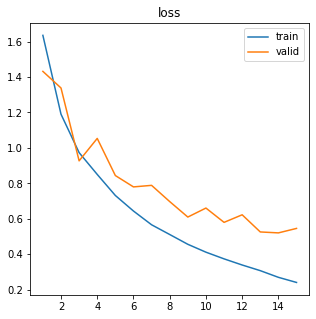

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(range(1,16)),train_batchnormalization_dropout_loss,label="train")
plt.plot(list(range(1,16)),valid_batchnormalization_dropout_loss,label="valid")
plt.title("loss")
plt.legend()

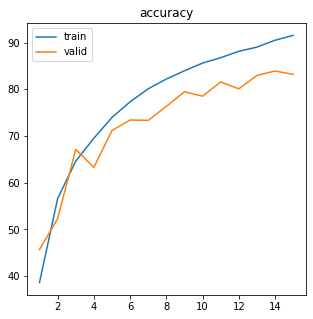

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(range(1,16)),train_batchnormalization_dropout_accuracy,label="train")
plt.plot(list(range(1,16)),valid_batchnormalization_dropout_accuracy,label="valid")
plt.title("accuracy")
plt.legend()

In [ ]:
model = VGG(num_classes=10, batch_normalization=False, dropout = True).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_dropout_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
def train():

  model.eval()
  correct = 0
  with torch.no_grad():
    for X,y in train_loader:  
      X = X.to(device)
      y = y.to(device)
      outputs,_ = model(X)
      correct += (outputs.argmax(dim=1) == y).sum()
  
  print("훈련 데이터 예측 정확도 : {}/{} ({:.2f}%)".format(correct,len(train_loader.dataset),100 * correct / len(train_loader.dataset)))

In [ ]:
def valid():

  model.eval()
  correct = 0
  with torch.no_grad():
    for X,y in valid_loader:  
      X = X.to(device)
      y = y.to(device)
      outputs,_ = model(X)
      correct += (outputs.argmax(dim=1) == y).sum()
  
  print("검증 데이터 예측 정확도 : {}/{} ({:.2f}%)".format(correct,len(valid_loader.dataset),100 * correct / len(valid_loader.dataset)))

In [ ]:
def test():

  model.eval()
  correct = 0
  with torch.no_grad():
    for X,y in test_loader:  
      X = X.to(device)
      y = y.to(device)
      outputs,_ = model(X)
      correct += (outputs.argmax(dim=1) == y).sum()
  
  print("테스트 데이터 예측 정확도 : {}/{} ({:.2f}%)".format(correct,len(test_loader.dataset),100 * correct / len(test_loader.dataset)))

In [ ]:
train()

훈련 데이터 예측 정확도 : 37693/40000 (94.23%)


In [ ]:
valid()

검증 데이터 예측 정확도 : 8332/10000 (83.32%)


In [ ]:
test()

테스트 데이터 예측 정확도 : 8251/10000 (82.51%)


In [ ]:
# lr scheduler train : 80.20% valid : 72.19% test : 72.51% # 0.01 train : 89.51% valid : 75.30% test : 76.03% # 0.001 train : 53.40% valid : 51.85% test : 52.27% # dropout 0.2 train : 86.23% valid : 78.22% test : 78.05% # batchnormalization train : 94.23% valid : 83.32% test : 82.51% # batchnormalization dropout train : 90.79% valid : 82.31% test : 81.47% # l2_regularization train : 64.77% valid : 62.05% test : 62.11% # image preprocessing train : 82.68% valid : 83.08% test : 83.17% # model train : 92.99% valid : 72.90% test : 73.80% dropout train : 92.85% valid : 77.81% test : 77.12% batchnormalization train : 86.88% valid : 77.71% test : 77.84%

# 이미지 필터 및 feature map 시각화

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 기존 모델

In [ ]:
for data in test_loader:
  
  images,label = data
  images = images.to(device)
  label = label.to(device)
  break

In [ ]:
image = images[0]

In [ ]:
model = VGG(num_classes=10, batch_normalization=False, dropout = False).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
def model_visualization(model,images):
  conv_layers = []
  model_weights = []

  for child in list(model.children()):
    if type(child) == nn.Conv2d:
      conv_layers.append(child)
      model_weights.append(child.weight)

    elif type(child) == nn.Sequential:
      for layer in child.children():
        if type(layer) == nn.Conv2d:
          conv_layers.append(layer)
          model_weights.append(layer.weight)

  results = [conv_layers[0](images)]
  for layer in range(1,len(conv_layers)):
    results.append(conv_layers[layer](results[-1]))
    outputs = results
  return outputs

def model_feature_map_visualization(model):
  conv_layers = []
  model_weights = []

  for child in list(model.children()):
    if type(child) == nn.Conv2d:
      conv_layers.append(child)
      model_weights.append(child.weight)

    elif type(child) == nn.Sequential:
      for layer in child.children():
        if type(layer) == nn.Conv2d:
          conv_layers.append(layer)
          model_weights.append(layer.weight)

  return model_weights,conv_layers

def visualization(model,image):
  
  model_weights,conv_layers = model_feature_map_visualization(model)
  outputs = []
  names = []
  for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

  processed = []
  for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

  return processed

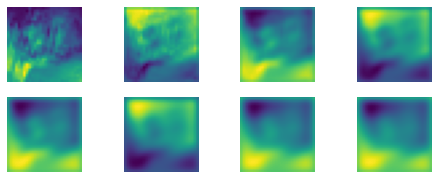

In [ ]:
processed = visualization(model,image)
fig = plt.figure(figsize=(8,8))
for i in range(len(processed)):
  a = fig.add_subplot(5,4,i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")

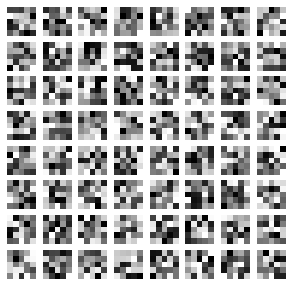

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")

In [ ]:
list(model.parameters())[14].size()

torch.Size([512, 512, 3, 3])

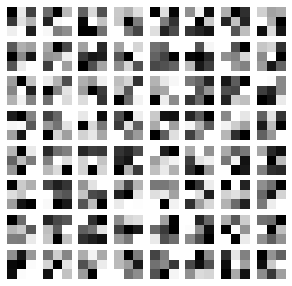

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[14]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")
  if i == 63 :
    break

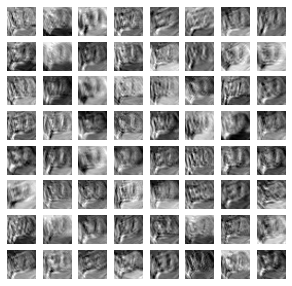

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[0][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")

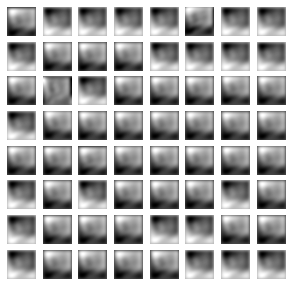

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[-1][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")
  if i == 63:
    break

# 드롭아웃

In [ ]:
model = VGG(num_classes=10, batch_normalization=False, dropout = True).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_dropout_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
outputs = model_visualization(model,images)

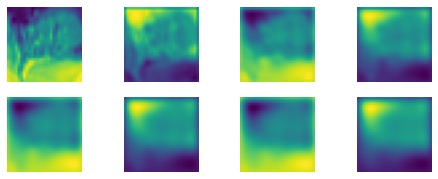

In [ ]:
processed = visualization(model,image)
fig = plt.figure(figsize=(8,8))
for i in range(len(processed)):
  a = fig.add_subplot(5,4,i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")

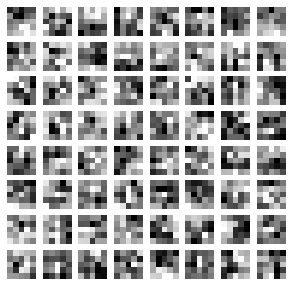

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")

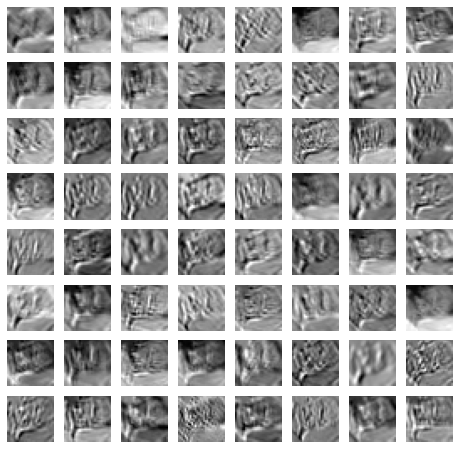

In [ ]:
plt.figure(figsize=(8,8))
for i, filter in enumerate(outputs[0][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")

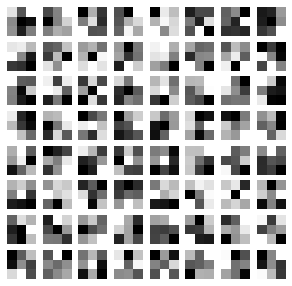

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[14]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")
  if i == 63:
    break

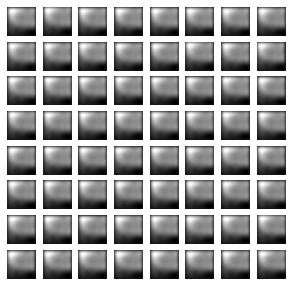

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[-1][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")
  if i == 63:
    break

# 배치정규화

In [ ]:
model = VGG(num_classes=10, batch_normalization=True, dropout = False).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
outputs = model_visualization(model,images)

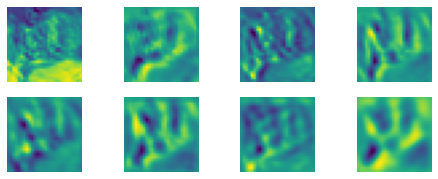

In [ ]:
processed = visualization(model,image)
fig = plt.figure(figsize=(8,8))
for i in range(len(processed)):
  a = fig.add_subplot(5,4,i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")

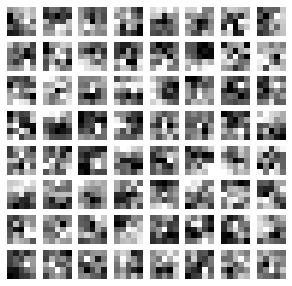

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")

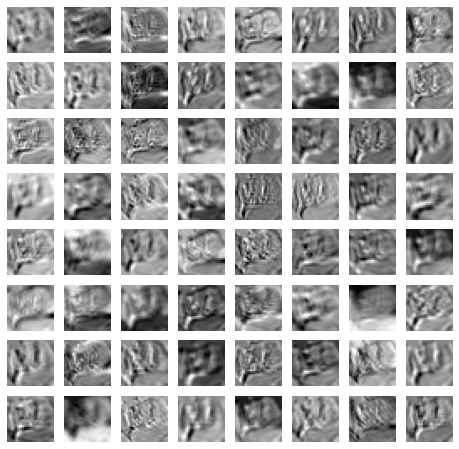

In [ ]:
plt.figure(figsize=(8,8))
for i, filter in enumerate(outputs[0][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")

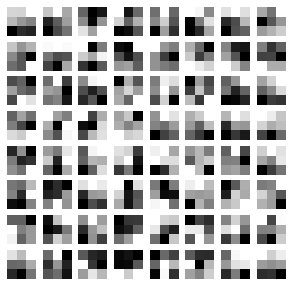

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[28]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")
  if i == 63:
    break

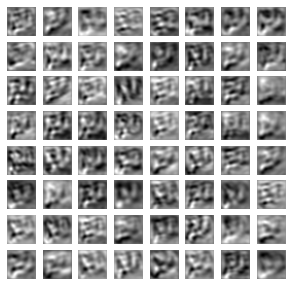

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[-1][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")
  if i == 63:
    break

# 배치정규화 & 드롭아웃

In [ ]:
model = VGG(num_classes=10, batch_normalization=True, dropout = True).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_dropout_checkpoint_14.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
outputs = model_visualization(model,images)

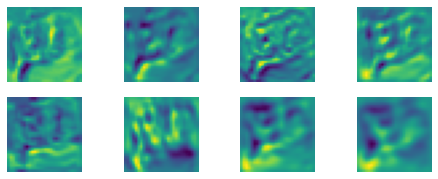

In [ ]:
processed = visualization(model,image)
fig = plt.figure(figsize=(8,8))
for i in range(len(processed)):
  a = fig.add_subplot(5,4,i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")

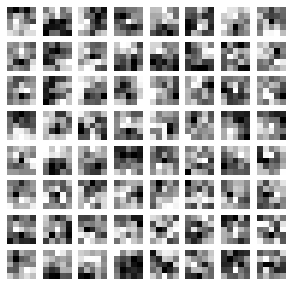

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")

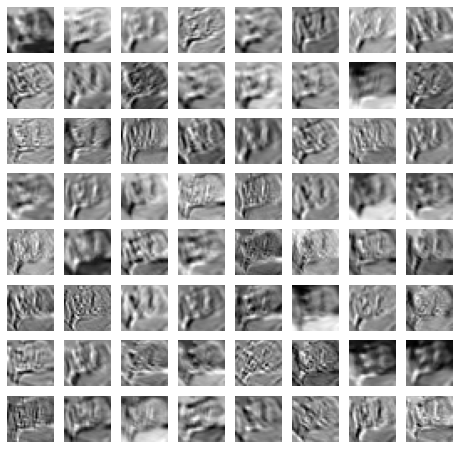

In [ ]:
plt.figure(figsize=(8,8))
for i, filter in enumerate(outputs[0][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")

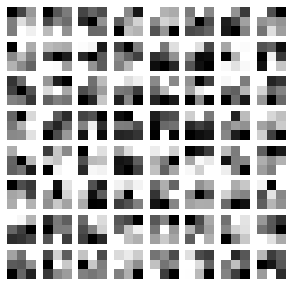

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[28]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")
  if i == 63:
    break

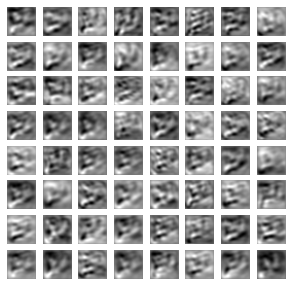

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[-1][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")
  if i == 63:
    break

# l2 규제

In [ ]:
model = VGG(num_classes=10, batch_normalization=False, dropout = False).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_l2_regularization_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
outputs = model_visualization(model,images)

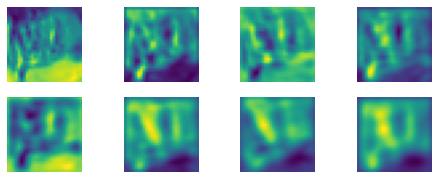

In [ ]:
processed = visualization(model,image)
fig = plt.figure(figsize=(8,8))
for i in range(len(processed)):
  a = fig.add_subplot(5,4,i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")

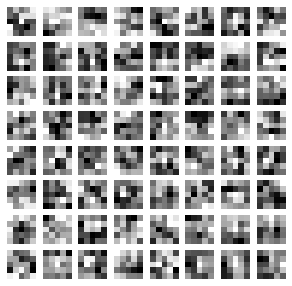

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")

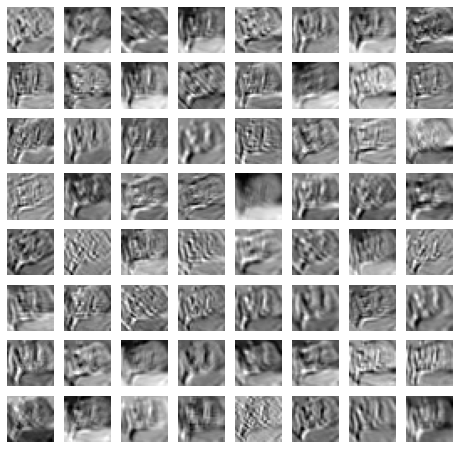

In [ ]:
plt.figure(figsize=(8,8))
for i, filter in enumerate(outputs[0][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")

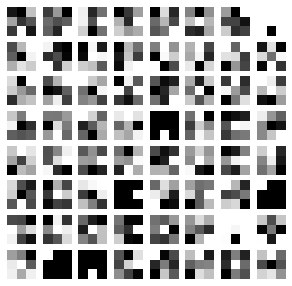

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[14]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")
  if i == 63:
    break

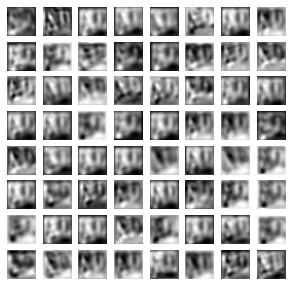

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[-1][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")
  if i == 63:
    break

# 이미지 전처리

In [ ]:
model = VGG(num_classes=10, batch_normalization=True, dropout = False).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_image_preprocessing_checkpoint_14.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
outputs = model_visualization(model,images)

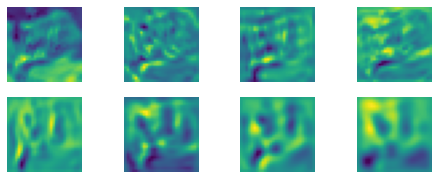

In [ ]:
processed = visualization(model,image)
fig = plt.figure(figsize=(8,8))
for i in range(len(processed)):
  a = fig.add_subplot(5,4,i+1)
  imgplot = plt.imshow(processed[i])
  a.axis("off")

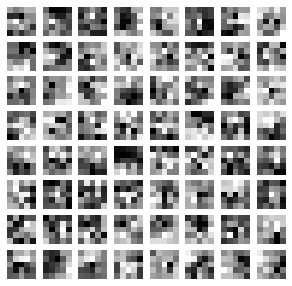

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")

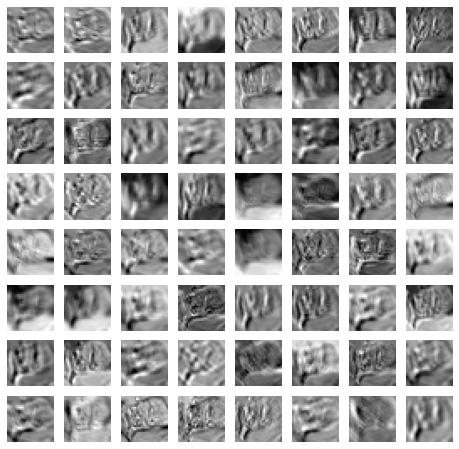

In [ ]:
plt.figure(figsize=(8,8))
for i, filter in enumerate(outputs[0][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")

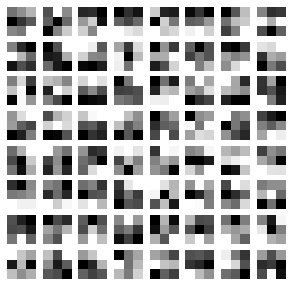

In [ ]:
plt.figure(figsize=(5,5))
for i , filter in enumerate(list(model.parameters())[28]):
  plt.subplot(8,8,i+1)
  plt.imshow(filter[0,:,:].detach().cpu(),cmap="gray")
  plt.axis("off")
  if i == 63:
    break

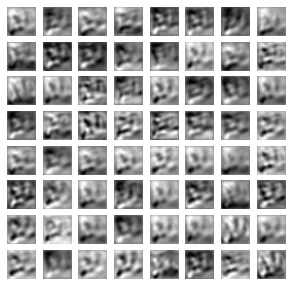

In [ ]:
plt.figure(figsize=(5,5))
for i, filter in enumerate(outputs[-1][0,:,:,:].detach().cpu()):
  plt.subplot(8,8,i+1)
  plt.imshow(filter,cmap="gray")
  plt.axis("off")
  if i == 63:
    break

# CAM 구현

In [ ]:
path_original = "/content/drive/MyDrive/model_checkpoint_15.pt"
path_batchnormalization = "/content/drive/MyDrive/model_batchnormalization_checkpoint_15.pt"
path_dropout = "/content/drive/MyDrive/model_dropout_checkpoint_15.pt"
path_batchnormalization_dropout = "/content/drive/MyDrive/model_batchnormalization_dropout_checkpoint_14.pt"
path_l2_regularization = "/content/drive/MyDrive/model_batchnormalization_l2_regularization_checkpoint_15.pt"
path_image_preprocessing = "/content/drive/MyDrive/model_batchnormalization_image_preprocessing_checkpoint_14.pt"

In [ ]:
def model_select(path,batchnormalization,dropout):

  model = VGG(num_classes=10, batch_normalization=batchnormalization, dropout = dropout).to(device)
  model_state_dict = torch.load(path,map_location=device)
  model.load_state_dict(model_state_dict["model_state_dict"])
  return model
model = model_select(path_batchnormalization,True,False)

In [ ]:
class CAM(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)

    for param in self.features.parameters():
      param.requires_grad = False
      
    self.pooling = model.avg_pool
    self.fc = nn.Linear(512,10)

  def forward(self,x):
    map = self.features(x)
    out = self.pooling(map)
    out = out.view(out.size(0),-1)
    out = self.fc(out)
    return out, map


In [ ]:
model_cam = CAM(model).to(device)

In [ ]:
for epoch in range(epochs):

  model.train()

  train_avg_loss = 0
  valid_avg_loss = 0
  train_correct = 0
  valid_correct = 0

  for X,y in train_loader:
    
    X = X.to(device)
    y = y.to(device)

    outputs,_ = model(X)
    train_correct += torch.sum(outputs.argmax(dim=1) == y).detach().cpu().item()

    loss = criterion(outputs,y)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    train_avg_loss += loss / len(train_loader)
  
  model_cam.eval()
  for X,y in valid_loader:
  
    with torch.no_grad():
      X = X.to(device)
      y = y.to(device)

      outputs, _ = model(X)
      valid_correct += torch.sum(outputs.argmax(dim=1) == y).detach().cpu().item()

      loss = criterion(outputs,y)
      valid_avg_loss += loss / len(valid_loader)

  print("epoch : {}일때 train loss : {:.3f} train accuracy : {:.2f}% valid loss : {:.3f} valid accuracy : {:.2f}%".format(epoch+1,train_avg_loss,train_correct / len(train_loader.dataset) * 100, valid_avg_loss, valid_correct / len(valid_loader.dataset) * 100))


epoch : 1일때 train loss : 0.133 train accuracy : 95.23% valid loss : 0.516 valid accuracy : 85.11%
epoch : 2일때 train loss : 0.133 train accuracy : 95.33% valid loss : 0.513 valid accuracy : 85.13%
epoch : 3일때 train loss : 0.133 train accuracy : 95.18% valid loss : 0.514 valid accuracy : 85.14%
epoch : 4일때 train loss : 0.134 train accuracy : 95.28% valid loss : 0.515 valid accuracy : 85.15%
epoch : 5일때 train loss : 0.133 train accuracy : 95.32% valid loss : 0.514 valid accuracy : 85.11%
epoch : 6일때 train loss : 0.133 train accuracy : 95.32% valid loss : 0.514 valid accuracy : 85.11%
epoch : 7일때 train loss : 0.134 train accuracy : 95.28% valid loss : 0.517 valid accuracy : 85.10%
epoch : 8일때 train loss : 0.134 train accuracy : 95.25% valid loss : 0.515 valid accuracy : 85.03%
epoch : 9일때 train loss : 0.135 train accuracy : 95.23% valid loss : 0.517 valid accuracy : 85.13%
epoch : 10일때 train loss : 0.134 train accuracy : 95.15% valid loss : 0.516 valid accuracy : 85.21%
epoch : 11일때 train 

In [ ]:
for data in test_loader:
  
  images,label = data
  images = images.to(device)
  label = label.to(device)
  outputs,f = model_cam(images)
  _,predicted = torch.max(outputs,1)
  break

In [ ]:
classes = ("airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck")
params = list(model_cam.parameters())

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

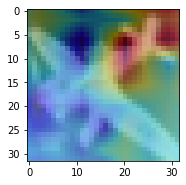

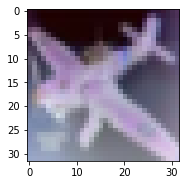

In [ ]:
for num in range(32):

  overlay = params[-2][int(predicted[num])].matmul(f[num].reshape(512,7*7)).reshape(7,7).cpu().data.numpy()
  overlay = overlay - np.min(overlay)
  overlay = overlay / np.max(overlay)

  img = images[num].cpu() / 2 + 0.5
  npimg = np.transpose(img.numpy(),(1,2,0))
  
  skimage.transform.resize(overlay,[32,32])
  
  if num == 27:

    plt.subplot(1,2,1)

    plt.imshow(npimg)
    plt.imshow(skimage.transform.resize(overlay,[32,32]),alpha=0.4,cmap = "jet")
    plt.show()

    plt.subplot(1,2,2)
    plt.imshow(npimg)
    plt.show()

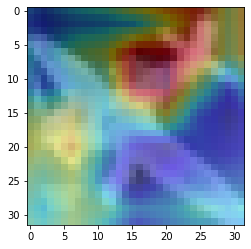

In [ ]:
num = 27
overlay = params[-2][int(predicted[num])].matmul(f[num].reshape(512,7*7)).reshape(7,7).cpu().data.numpy()
overlay = overlay - np.min(overlay)
overlay = overlay / np.max(overlay)

img = images[num].cpu() / 2 + 0.5
npimg = np.transpose(img.numpy(),(1,2,0))
  
skimage.transform.resize(overlay,[32,32])

plt.imshow(npimg)
plt.imshow(skimage.transform.resize(overlay,[32,32]),alpha=0.4,cmap = "jet")
plt.show()

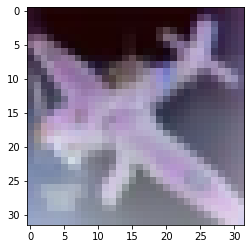

In [ ]:
plt.imshow(npimg)
plt.show()

# Feature Extractor

In [ ]:
path_original = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_15.pt"
path_batchnormalization = "/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_checkpoint_15.pt"
path_dropout = "/content/drive/MyDrive/Colab Notebooks/model_dropout_checkpoint_15.pt"
path_batchnormalization_dropout = "/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_dropout_checkpoint_14.pt"
path_l2_regularization = "/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_l2_regularization_checkpoint_15.pt"
path_image_preprocessing = "/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_image_preprocessing_checkpoint_14.pt"

def model_select(path,batchnormalization,dropout):

  model = VGG(num_classes=10, batch_normalization=batchnormalization, dropout = dropout).to(device)
  model_state_dict = torch.load(path,map_location=device)
  model.load_state_dict(model_state_dict["model_state_dict"])
  new_model = FeatureExtractor(model).to(device)
  return new_model,model
new_model,model = model_select(path_image_preprocessing,True,False)

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
    self.pooling = model.pooling
    self.fc = model.fc

  def forward(self,x):
    out = self.features(x)
    feature_vector = self.pooling(out)
    out = feature_vector.view(feature_vector.size(0),-1)
    out = self.fc(out)
    return out,feature_vector

In [ ]:
model_feature_extractor = FeatureExtractor(model_cam)

In [ ]:
model_feature_extractor.eval()

features = torch.ones((32,512))
labels = [-1]
with torch.no_grad():
  for X,y in test_loader:
    X = X.to(device)
    y = y.to(device)

    _,feature = model_feature_extractor(X)
    feature = feature.cpu().detach()
    feature = feature.view(feature.size(0),-1)
    features = torch.cat((features,feature),dim=0)
    labels += y.detach().cpu().tolist()


In [ ]:
new_model.eval()

features = torch.ones((32,512))
labels = [-1]
with torch.no_grad():
  for X,y in test_loader:
    X = X.to(device)
    y = y.to(device)

    feature = new_model(X)
    feature = feature.cpu().detach()
    features = torch.cat((features,feature),dim=0)
    labels += y.detach().cpu().tolist()


In [ ]:
features = features[32:]
features = np.array(features)
labels = labels[1:]

In [ ]:
tsne = TSNE(n_iter=1000,perplexity = 50)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
tsne_features = tsne.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tx, ty = tsne_features[:,0], tsne_features[:,1]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

scaler = StandardScaler()
pca_features = scaler.fit_transform(pca_features)
pca_plot = pd.DataFrame(pca_features,columns=["x","y"])

tsne_plot = pd.DataFrame({"x":tx,"y":ty,"label":labels})
pca_plot["label"] = labels

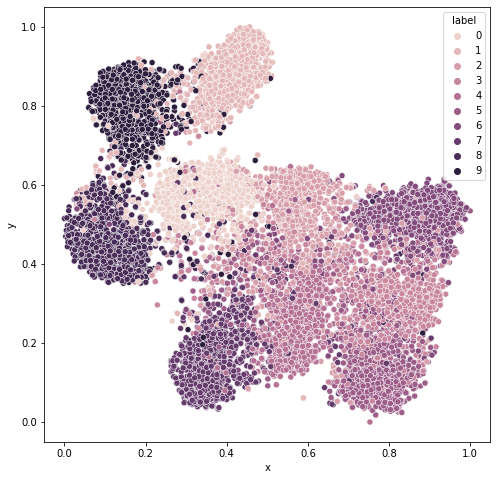

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x="x",y="y",data=tsne_plot,hue="label",legend="full")

In [ ]:
gmm = GaussianMixture(n_components=10)
kmeans = KMeans(n_clusters=10)
kmeans.fit(tsne_features)
gmm.fit(tsne_features)
gmm_label = gmm.predict(tsne_features)
kmeans_label = kmeans.labels_
tsne_plot["gmm_label"] = gmm_label
tsne_plot["kmeans_label"] = kmeans_label

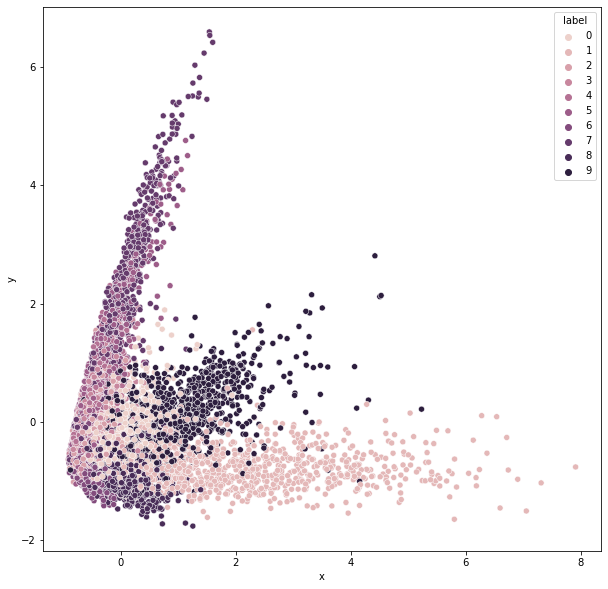

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="x",y="y",data=pca_plot,hue="label",legend="full")

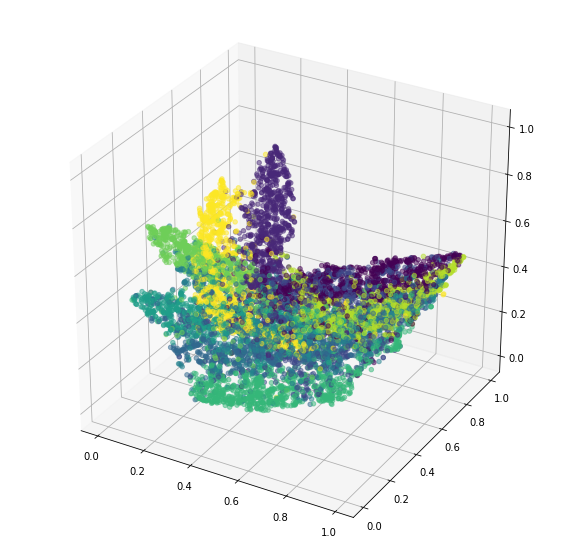

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
ax.scatter(tsne_plot_3d["x"],tsne_plot_3d["y"],tsne_plot_3d["z"],alpha=0.5,c=tsne_plot_3d["label"])
plt.show()

# contrastive learning

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,train,X,y,p=0.5,transform=None):

    self.train = train
    self.X = X
    self.y = y
    self.X = torch.FloatTensor(self.X).permute(0,3,1,2)
    self.y = torch.LongTensor(self.y)
    self.transform = transform
    self.p = p

    self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.p, 
                                                                                                                 0.8*self.p, 
                                                                                                                 0.8*self.p, 
                                                                                                                 0.2*self.p)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])


  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):

    img = self.X[index]
    label = self.y[index]

    if self.transform is not None:
      img = self.transform(img)

    img1 = self.augmentation(img)
    img2 = self.augmentation(img)

    return (img1, img2, label)

  def augmentation(self,img):

    if self.train == True:
      img = self.transforms(img)
      
      return img
    else :
      return img

In [ ]:
train_tensor = CustomDataset(True,X_train,y_train,0.5,transform=transform)
train_loader = DataLoader(train_tensor,batch_size=128,shuffle=True,drop_last=True)
valid_tensor = CustomDataset(False,X_valid,y_valid,0.5,transform=transform)
valid_loader = DataLoader(valid_tensor,batch_size=128,drop_last=True)

In [ ]:
model = VGG(num_classes=10, batch_normalization=True).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/Colab Notebooks/model_batchnormalization_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class Contrastive_Learning(nn.Module):
  def __init__(self,model):
    super().__init__()

    self.model = model
    self.model.classifier = Identity()

    for p in self.model.parameters():
      p.requires_grad = True

    self.projector = ProjectionHead(512,512,128)

  def forward_once(self,x):

    out,_ = self.model(x)

    xp = self.projector(torch.squeeze(out))

    return xp
  
  def forward(self,input1,input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)

    return output1, output2 


In [ ]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [ ]:
net = Contrastive_Learning(model).to(device)

In [ ]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [ ]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


In [ ]:
optimizer = optim.Adam(net.parameters(),lr=0.001)
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

In [ ]:
nr = 0
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

nr = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []
train_avg_loss = 0
valid_avg_loss = 0

for epoch in range(15):

  model.train()

  for i, data in enumerate(train_loader):

    img1, img2, label = data[0], data[1], data[2]
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    optimizer.zero_grad()
    output1, output2 = net(img1,img2)
    loss = criterion(output1,output2)
    loss.backward()
    optimizer.step()

    train_avg_loss += loss / len(train_loader)

  train_loss.append(train_avg_loss.detach().cpu().item())

  model.eval()
  with torch.no_grad():

    for i, data in enumerate(valid_loader):

      img1, img2, label = data[0], data[1], data[2]
      img1, img2, label = img1.to(device), img2.to(device), label.to(device)

      output1, output2 = net(img1,img2)
      loss = criterion(output1,output2)

      valid_avg_loss += loss / len(valid_loader)

      
    valid_loss.append(valid_avg_loss.detach().cpu().item())

  torch.save({
      "epoch" : epoch + 1,
      "optimizer_state_dict":optimizer.state_dict(),
      "model_state_dict":net.state_dict(),
      "train_loss":train_avg_loss,
      "valid_loss":valid_avg_loss,
      "description" : f"체크포인트 {epoch + 1}"
  },f"/content/drive/MyDrive/model_contrastive_learning_checkpoint_{epoch + 1}.pt")

  print("epoch : {}일때 train loss : {:.3f} valid loss : {:.3f}".format(epoch+1,train_avg_loss, valid_avg_loss))






epoch : 1일때 train loss : nan valid loss : nan


KeyboardInterrupt: ignored

In [ ]:
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(epochs):
  
  lr_scheduler.step()

  model.train()
  
  train_avg_loss = 0
  valid_avg_loss = 0
  train_correct = 0
  valid_correct = 0

  for X,y in train_loader:
    
    X = X.to(device)
    y = y.to(device)

    outputs,_ = model(X)
    train_correct += torch.sum(outputs.argmax(dim=1) == y).detach().cpu().item()

    loss = criterion(outputs,y)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    train_avg_loss += loss / len(train_loader)
  
  train_accuracy.append(train_correct / len(train_loader.dataset) * 100)
  train_loss.append(train_avg_loss.detach().cpu().item())
  
  model.eval()
  for X,y in valid_loader:
  
    with torch.no_grad():
      X = X.to(device)
      y = y.to(device)

      outputs,_ = model(X)
      valid_correct += torch.sum(outputs.argmax(dim=1) == y).detach().cpu().item()

      loss = criterion(outputs,y)
      valid_avg_loss += loss / len(valid_loader)

  valid_accuracy.append(valid_correct / len(valid_loader.dataset) * 100)
  valid_loss.append(valid_avg_loss.detach().cpu().item())

  torch.save({
      "epoch" : epoch + 1,
      "optimizer_state_dict":optimizer.state_dict(),
      "model_state_dict":model.state_dict(),
      "train_loss":train_avg_loss,
      "valid_loss":valid_avg_loss,
      "description" : f"체크포인트 {epoch + 1}"
  },f"/content/drive/MyDrive/model_batchnormalization_dropout_checkpoint_{epoch + 1}.pt")

  print("epoch : {}일때 train loss : {:.3f} train accuracy : {:.2f}% valid loss : {:.3f} valid accuracy : {:.2f}%".format(epoch+1,train_avg_loss,train_correct / len(train_loader.dataset) * 100, valid_avg_loss, valid_correct / len(valid_loader.dataset) * 100))

# 참고

In [ ]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

In [ ]:
def set_seed(seed = 16):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

!tar -xf /content/cifar-10-python.tar.gz

--2022-05-30 01:40:47--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.1MB/s    in 3.9s    

2022-05-30 01:40:52 (41.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
train_files = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
images = np.array([],dtype=np.uint8).reshape((0,3072))
labels = np.array([])
for tf in train_files:
    data_dict = unpickle('/content/cifar-10-batches-py/'+tf)
    data = data_dict[b'data']
    images = np.append(images,data,axis=0)
    labels = np.append(labels,data_dict[b'labels'])
#print(images.shape, labels.shape)

testimages = np.array([],dtype=np.uint8).reshape((0,3072))
testlabels = np.array([])

data_dict = unpickle('/content/cifar-10-batches-py/test_batch')
data = data_dict[b'data']
testimages = np.append(testimages,data,axis=0)
testlabels = np.append(testlabels,data_dict[b'labels'])
#print(testimages.shape, testlabels.shape)

images = images.reshape((-1,3,32,32)).astype(np.float)
testimages = testimages.reshape((-1,3,32,32)).astype(np.float)

lab_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]
MEAN = np.mean(trimages/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(trimages/255.0,axis=(0,2,3),keepdims=True)
print(MEAN)

[[[[0.49145363]]

  [[0.48206213]]

  [[0.44622512]]]]


In [ ]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

In [ ]:
dg = C10DataGen('train',trimages)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

vdg = C10DataGen('valid',valimages)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model):
        super().__init__()
      
        #PRETRAINED MODEL
        self.pretrained = base_model
        self.pretrained.classifier = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(512, 512, 128)

    def forward(self,x):
        out,_ = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp

In [ ]:
model = VGG(num_classes=10, batch_normalization=True).to(device)
model_state_dict = torch.load("/content/drive/MyDrive/model_batchnormalization_checkpoint_15.pt",map_location=device)
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
net = PreModel(model).to(device)

In [ ]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [ ]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [ ]:
#OPTMIZER
optimizer = LARS(
    [params for params in net.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


In [ ]:
def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('/content/saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

def plot_features(model, num_classes, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)
            out = net(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

In [ ]:
nr = 0
current_epoch = 0
epochs = 15
tr_loss = []
val_loss = []

for epoch in range(15):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    net.train()
    tr_loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dl):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = net(x_i)
        z_j = net(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        tr_loss_epoch += loss.item()

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    net.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(vdl):
        
          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i = net(x_i)
          z_j = net(x_j)

          loss = criterion(z_i, z_j)

          if nr == 0 and step % 50 == 0:
              print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    if nr == 0:
        tr_loss.append(tr_loss_epoch / len(dl))
        val_loss.append(val_loss_epoch / len(vdl))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")



Epoch [0/15]	
Step [0/312]	 Loss: 4.00202
Step [50/312]	 Loss: 3.88394
Step [100/312]	 Loss: 3.87792
Step [150/312]	 Loss: 3.85125
Step [200/312]	 Loss: 3.82691
Step [250/312]	 Loss: 3.82429
Step [300/312]	 Loss: 3.81042
Adjusting learning rate of group 0 to 4.0000e-02.
Step [0/78]	 Loss: 3.69878
Step [50/78]	 Loss: 3.68908
Epoch [0/15]	 Training Loss: 3.8664406591500993	 lr: 0.04
Epoch [0/15]	 Validation Loss: 3.672853261996538	 lr: 0.04
Epoch [0/15]	 Time Taken: 7.285979930559794 minutes
Epoch [1/15]	
Step [0/312]	 Loss: 3.82827
Step [50/312]	 Loss: 3.80517
Step [100/312]	 Loss: 3.82891
Step [150/312]	 Loss: 3.7937
Step [200/312]	 Loss: 3.79366
Step [250/312]	 Loss: 3.78353
Step [300/312]	 Loss: 3.78979
Adjusting learning rate of group 0 to 6.0000e-02.
Step [0/78]	 Loss: 3.69217
Step [50/78]	 Loss: 3.6712
Epoch [1/15]	 Training Loss: 3.799788469687486	 lr: 0.06
Epoch [1/15]	 Validation Loss: 3.664747519370837	 lr: 0.06
Epoch [1/15]	 Time Taken: 7.395891253153483 minutes
Epoch [2/15]	

In [ ]:
torch.save({"model_state_dict":net.state_dict()},"/content/drive/MyDrive/model_representation_learning.pt")

In [ ]:
net

PreModel(
  (pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): BatchNorm2d(512, eps=1e-0

In [ ]:
net.load_state_dict(torch.load("/content/drive/MyDrive/model_representation_learning.pt",map_location=device)["model_state_dict"])

<All keys matched successfully>

In [ ]:
net.eval()

features = torch.ones((128,128))
with torch.no_grad():
  for X,y in vdl:
    X = X.squeeze().to(device).float()

    feature = net(X)
    feature = feature.cpu().detach()
    features = torch.cat((features,feature),dim=0)

In [ ]:
features[128:].shape

torch.Size([9984, 128])

In [ ]:
vallabels[:-16]

9984

In [ ]:
features = features[128:]
features = np.array(features)
labels = vallabels[:-16]

tsne = TSNE(n_iter=1000,perplexity=50)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
tsne_features = tsne.fit_transform(features)

tx, ty = tsne_features[:,0], tsne_features[:,1]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

scaler = StandardScaler()
pca_features = scaler.fit_transform(pca_features)
pca_plot = pd.DataFrame(pca_features,columns=["x","y"])

tsne_plot = pd.DataFrame({"x":tx,"y":ty,"label":labels})
pca_plot["label"] = labels

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: ignored